**NOTEBOOK 3: TRI-LAYERED COMPUTATIONAL MODEL OF THE THORACIC AORTA**

Alessandro Giudici (a.giudici@maastrichtuniversity.nl) and Mobina Izadpanah (mobina.izadpanah@maastrichtuniversity.nl)

In this last workbook, we will follow the main steps involved in the formulation of a multiscale constitutive model that relates the organ-level biomechanics of the (pig) aorta to the individual contributions of its three layers: the intima, the media, and the adventitia.

In [ ]:
# Importing relevant python packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

**3.1 Setting-up the building-blocks of the tri-layered model**

*3.1.1. Constitutive law*

The tri-layered model of the pig aorta consists of the composition of three thin-walled models of the three arterial layers (the intima, media, and adventitia), opportunely spaced to account for their individual thicknesses and constrained to deform together under the effect of tissue-level deformation/loads.

The mechanical behaviour of the three layers is described by the same Gasser-Ogden-Holzapfel (GOH) constitutive law:

$$
Ψ = \mu(I_1 - 3) + \frac{k_1}{k_2} \{e^{k_2[\rho I_1 + (1-3\rho) I_4 - 1]^2}-1\}\text{ },
$$

where
*   $\mu$ is a stiffness-like parameter of the matrix (predominantly representing elastin's behaviour),
*   $I_1=\lambda_{\theta}^2+\lambda_z^2+\lambda_r^2$ is the first invariant of the deformation gradient $\textbf{F}$,
*   $k_1$ is a stiffness-like parameter of the collagen fibre,
*   $k_2$ is a non-linearity parameter describing the gradual recruitment of collagen fibres with increasing deformation,
*   $\rho \in [0, 1/3]$ is a fibre orientation dispersion parameter, and
*   $I_4 = \lambda_{\theta}^2 \cos^2(\alpha) + \lambda_z^2 \sin^2(\alpha)\text{ }$ is the fourth invariant of the deformation gradient $\textbf{F}$.

In $I_1$ and $I_4$, $\lambda_\theta$, $\lambda_z$ and $\lambda_r$ denote the circumferential, axial, and radial components of the vessel deformation graident $\mathbf{F} = \text{diag}[\lambda_r, \lambda_{\theta},\lambda_z]$, respectively, and $\alpha$ is the fibre principal orientation.

Based on this model, the python function below calculates the elastic energy density, the stress tensor, and the circumferential and axial stiffnesses of the tissue given the model parameters and (a description of) the deformation gradient $\textbf{F}$.

In [ ]:
def TwoFibreFamilyDispersion(parameterV,lambdaM,activatorV):
    """"
    The function returns the circumferential, axial, and radial extra Cauchy stresses, the stored elastic energy, and
    the small-on-large circumferential and axial material stiffnesses for a Gasser-Ogden-Holzapfel (Two fibre model
    with fibre dispersion) constitutive model modified to include deposition stretches. Input parameters are a vector
    parameterV of model parameters, the deformation vectors in the three principal directions, and an activator that
    activates/deactivates the contribution from each wal constituent.

    For a detailed description of the constitutive model refer to Gasser et al. Hyperelastic modelling of arterial
    layers with distributed collagen fibre orientations. Journal of the Royal Society Interface, 3, pp.15-35, 2006.

    parameterV is the 8-element vector of model parameters where:
       position 0: elastin stiffness-like parameter
       position 1: diagonally oriented collagen fibre stiffness-like parameter
       position 2: diagonally oriented collagen fibre non-linearity parameter
       position 3: diagonally oriented collagen fibre orientation parameter with respect to the circumferential direction
       position 4: collagen fibre dispersion parameter

    For a detailed description of the small-on-large formulation refer to Baek et al. Theory of small on large:
    Potential utility in computations of fluid-solid interactions in arteries. Computer methods in applied mechanics
    and engineering 2007, 196(31-32), pp.3070-3078.
    """

    # Re-assigning parameters
    mu = parameterV[0] # matrix stiffness-like parameter in [kPa]
    k_1 = parameterV[1] # fibre stiffness-like parameter in [kPa]
    k_2 = parameterV[2] # fibre non-linearity parameter adimensional [-]
    alpha = parameterV[3] * np.pi / 180 # fibre preferential orientation, converted to radians [rad]
    rho = parameterV[4] # fibre orientation dispersion parameter [-]

    # Initialising output vectors
    sigmaM = np.zeros(np.shape(lambdaM))
    C_M = np.zeros(np.shape(lambdaM))

    # First invariant for matrix
    I1 = lambdaM[:,0]**2 + lambdaM[:,1]**2 + lambdaM[:,2]**2

    # Fourth invariant for fibres
    I4_fibre = (lambdaM[:,0] * np.cos(alpha))**2 + (lambdaM[:,1] * np.sin(alpha))**2

    # Total fibre stretch squared
    lambda2_fibre = rho * I1 + (1 - 3 * rho) * I4_fibre

    ## Computing output variables
    # Strain energy density definition
    W_matrix = mu * (I1 - 3)
    W_fibre = k_1 / k_2 * (np.exp(k_2 * (lambda2_fibre - 1)**2) - 1)
    W = activatorV[0] * W_matrix + activatorV[1] * W_fibre

    # Circumferential extra Cauchy stress
    sigmatt_matrix = 2 * mu * lambdaM[:,0]**2
    sigmatt_fibre = (4 * k_1 * (rho + (1 - 3 * rho) * np.cos(alpha)**2)
                     * lambdaM[:,0]**2 * (lambda2_fibre - 1) * np.exp(k_2 * (lambda2_fibre - 1)**2)
                     )
    sigmaM[:,0] = activatorV[0] * sigmatt_matrix + activatorV[1] * sigmatt_fibre # sigmatt

    # Axial extra Cauchy stress
    sigmazz_matrix = 2 * mu * lambdaM[:,1]**2
    sigmazz_fibre = (4 * k_1 * (rho + (1 - 3 * rho) * np.sin(alpha)**2)
                     * lambdaM[:,1]**2 * (lambda2_fibre - 1) * np.exp(k_2 * (lambda2_fibre - 1)**2)
                     )
    sigmaM[:,1] = activatorV[0] * sigmazz_matrix + activatorV[1] * sigmazz_fibre # sigmazz

    # Radial extra Cauchy stress
    sigmarr_matrix = 2 * mu * lambdaM[:,2]**2
    sigmarr_fibre = k_1 * rho * lambdaM[:,2]**2 * (lambda2_fibre - 1) * np.exp(k_2 * (lambda2_fibre - 1)**2)
    sigmaM[:,2] = activatorV[0] * sigmarr_matrix + activatorV[1] * sigmarr_fibre # sigmarr

    # Circumferential stiffness
    Ctttt_matrix = 2 * sigmatt_matrix
    Ctttt_fibre = (2 * sigmatt_fibre + 8 * k_1 * lambdaM[:,0]**4 * (1 + 2 * k_2 * (lambda2_fibre - 1)**2)
                   * (rho + (1 - 3 * rho) * np.cos(alpha)**2)**2 * np.exp(k_2 * (lambda2_fibre - 1)**2)
                   )
    C_M[:,0] = activatorV[0] * Ctttt_matrix + activatorV[1] * Ctttt_fibre

    # Axial stiffness
    Czzzz_matrix = 2 * sigmazz_matrix
    Czzzz_fibre = (2 * sigmazz_fibre + 8 * k_1 * lambdaM[:,1]**4 * (1 + 2 * k_2 * (lambda2_fibre - 1)**2)
                   * (rho + (1 - 3 * rho) * np.sin(alpha)**2)**2 * np.exp(k_2 * (lambda2_fibre - 1)**2)
                   )
    C_M[:,1] = activatorV[0] * Czzzz_matrix + activatorV[1] * Czzzz_fibre

    return sigmaM, W, C_M

*3.1.2. Layer-specific mechanical properties*

Now, using the GOH constitutive model described above, we will define the individual mechanical (i.e., model parameters) and geometrical (i.e., thickness) properties of the three arterial layers.

In [ ]:
## INTIMAL LAYER ##
# Constitutive model parameters
mu_intima = 19.0      # matrix stiffness-like parameter in [kPa]
k1_intima = 364/2     # fibre stiffness-like parameter in [kPa]
k2_intima = 12.09     # fibre non-linearity parameter in [-]
alpha_intima = 25.61  # fibre preferential orientation in [°]
rho_intima = 0.24     # fibre orientation dispersion parameter in [-]

# creating an array of intimal model parameters
parV_intima = np.array([mu_intima, k1_intima, k2_intima, alpha_intima, rho_intima])

# Geometrical parameters of the intima
H_intima = 0.245      # thickness of the isolated intima in [mm]


## MEDIAL LAYER ##
# Constitutive model parameters
mu_media = 36.0       # matrix stiffness-like parameter in [kPa]
k1_media = 343/2      # fibre stiffness-like parameter in [kPa]
k2_media = 7.24       # fibre non-linearity parameter in [-]
alpha_media = 30.63   # fibre preferential orientation in [°]
rho_media = 0.17      # fibre orientation dispersion parameter in [-]

# creating an array of intimal model parameters
parV_media = np.array([mu_media, k1_media, k2_media, alpha_media, rho_media])

# Geometrical parameters of the intima
H_media = 0.525      # thickness of the isolated intima in [mm]


## ADVENTITIAL LAYER ##
# Constitutive model parameters
mu_adventitia = 13.0       # matrix stiffness-like parameter in [kPa]
k1_adventitia = 40/2       # fibre stiffness-like parameter in [kPa]
k2_adventitia = 80.68      # fibre non-linearity parameter in [-]
alpha_adventitia = 38.30    # fibre preferential orientation in [°]
rho_adventitia = 0.23      # fibre orientation dispersion parameter in [-]

# creating an array of intimal model parameters
parV_adventitia = np.array([mu_adventitia, k1_adventitia, k2_adventitia, alpha_adventitia, rho_adventitia])

# Geometrical parameters of the intima
H_adventitia = 0.515      # thickness of the isolated intima in [mm]

Given these layer-specific parameters, we can simulate their individual response to planar equibiaxial stretching (see figure below) in the circumferential (i.e., diameter) and axial (i.e., along the vessel main axis) directions to appreciate differences in their mechanics (e.g., non-linearity of the response and degree of anisotropy).

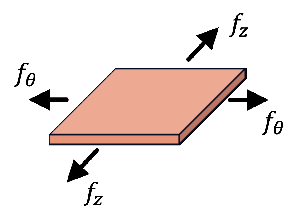

*Figure 1 - Schematic of planar biaxial testing.*

By looking at the layer-specific model parameters, you may be able to tell already which layer will be most anisotropic and "non-linear". For example:
* Which parameter or set of parameters is more indicative of non-linearity in the stress-stretch response?
* Which parameter or set of parameters controls the difference in axial and circumferential responses to deformation?

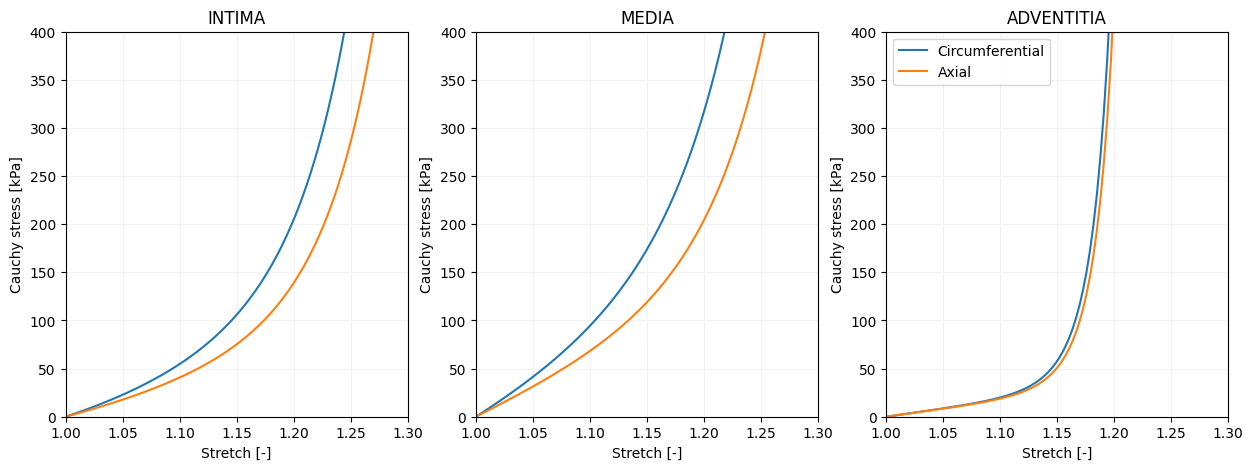

In [ ]:
# Let's define the equibiaxial deformation
lambda_theta = np.linspace(1,1.3,100) # circumferential deformation
lambda_z = lambda_theta # setting the axial deformation to be equal to the circumferential one
lambda_r = 1 / (lambda_theta * lambda_z) # the radial deformation follows from the incompressibility condition

# Defining the deformation tensor F
lambdaM = np.zeros((100,3))
lambdaM[:,0] = lambda_theta
lambdaM[:,1] = lambda_z
lambdaM[:,2] = lambda_r

# Simulating the equibiaxial extension of the intima
[SigmaM_intima, _, _] = TwoFibreFamilyDispersion(parV_intima, lambdaM, [1,1])

# Simulation the equibiaxial extension of the media
[SigmaM_media, _, _] = TwoFibreFamilyDispersion(parV_media, lambdaM, [1,1])

# Simulation the equibiaxial extension of the adventitia
[SigmaM_adventitia, _, _] = TwoFibreFamilyDispersion(parV_adventitia, lambdaM, [1,1])

# Applying the Lagrange multiplier to enforce incompressibiliy
for iCoordinate in range (0,3):
  SigmaM_intima[:,iCoordinate] = SigmaM_intima[:,iCoordinate] - SigmaM_intima[:,2]
  SigmaM_media[:,iCoordinate] = SigmaM_media[:,iCoordinate] - SigmaM_media[:,2]
  SigmaM_adventitia[:,iCoordinate] = SigmaM_adventitia[:,iCoordinate] - SigmaM_adventitia[:,2]

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.plot(lambdaM[:,0],SigmaM_intima[:,0])
plt.plot(lambdaM[:,1],SigmaM_intima[:,1])
plt.title('INTIMA')
plt.ylabel('Cauchy stress [kPa]')
plt.xlabel('Stretch [-]')
plt.axis([1, 1.3, 0, 400])
plt.grid(visible=True,color='0.95')

plt.subplot(1,3,2)
plt.plot(lambdaM[:,0],SigmaM_media[:,0])
plt.plot(lambdaM[:,1],SigmaM_media[:,1])
plt.title('MEDIA')
plt.ylabel('Cauchy stress [kPa]')
plt.xlabel('Stretch [-]')
plt.axis([1, 1.3, 0, 400])
plt.grid(visible=True,color='0.95')

plt.subplot(1,3,3)
plt.plot(lambdaM[:,0],SigmaM_adventitia[:,0])
plt.plot(lambdaM[:,1],SigmaM_adventitia[:,1])
plt.title('ADVENTITIA')
plt.ylabel('Cauchy stress [kPa]')
plt.xlabel('Stretch [-]')
plt.legend({'Circumferential','Axial'})
plt.axis([1, 1.3, 0, 400])
plt.grid(visible=True,color='0.95')


**3.2. Composing the tri-layered wall model and simulating planar biaxial testing**

The composite tri-layered arterial wall is not a simple weighted summation of the individual responses of the three arterial layers. Upon physical isolation from the wall, each layer undergoes a deformation, releasing the reasidual stresses it is subjected to when part of the wall (even in the absence of external loads). Therefore, building a tri-layered wall model requires accounting for these layer-specific deformations to attain a physiological residual stress distribution across the wall thickness.

These layer-specific deformations are defined through residual stress deformation gradients $\textbf{G}_{\text{residual},i}$, with $i=\{\text{intima, media, adventitia}\}$. Given the tissue-level deformation acting at the whole artery-level, these layer-specific deformation gradients determine the actual deformation acting on each individual layer.

In [ ]:
# Intimal deformation gradient to capture the residual stresses
G_res_intima = np.array([1.020, 0.987, 1/(1.020 * 0.987)])

# Medial deformation gradient to capture the residual stresses
G_res_media = np.array([0.997, 0.979, 1/(0.997 * 0.979)])

# Adventitial deformation gradient to capture the residual stresses
G_res_adventitia = np.array([0.943, 1.061, 1/(0.943 * 1.061)])

We can now simulate the response of the tri-layered arterial wall model to the same equibiaxial deformation applied earlier to the individual layers. Given the individual layers' stresses, the total wall stress for a planar biaxial deformation can be calculated by integrating stresses over the wall thickness, or, under the thin-wall assumption, as:

$$
\mathbf{\sigma}_\text{wall} = \frac{\mathbf{\sigma}_\text{intima} h_\text{intima} + \mathbf{\sigma}_\text{media} h_\text{media}+\mathbf{\sigma}_\text{adventitia} h_\text{adventitia}}{h_\text{wall}}
$$

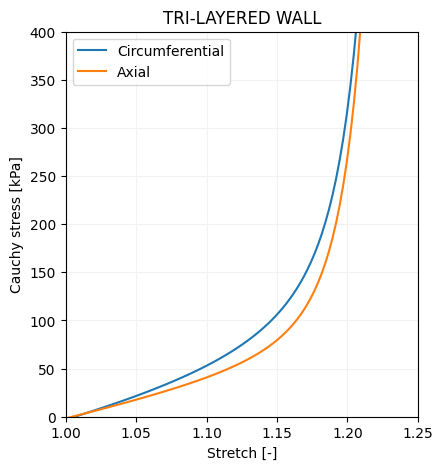

In [ ]:
# Let's define the equibiaxial deformation
lambda_theta = np.linspace(1,1.25,100) # circumferential deformation
lambda_z = lambda_theta # setting the axial deformation to be equal to the circumferential one
lambda_r = 1 / (lambda_theta * lambda_z) # the radial deformation follows from the incompressibility condition

# Defining the vessel deformation tensor F
lambdaM = np.zeros((100,3))
lambdaM[:,0] = lambda_theta
lambdaM[:,1] = lambda_z
lambdaM[:,2] = lambda_r

# Now, the layer-specific deformation tensors can be determined by the simple composition of the
# layer-specific residual stress deformation gradient G and thevessel deformation gradient F
lambdaM_intima = lambdaM * G_res_intima
lambdaM_media = lambdaM * G_res_media
lambdaM_adventitia = lambdaM * G_res_adventitia

# Simulating the equibiaxial extension of the intima when part of the wall
[SigmaM_intima, _, _] = TwoFibreFamilyDispersion(parV_intima, lambdaM_intima, [1,1])

# Simulation the equibiaxial extension of the media when part of the wall
[SigmaM_media, _, _] = TwoFibreFamilyDispersion(parV_media, lambdaM_media, [1,1])

# Simulation the equibiaxial extension of the adventitia when part of the wall
[SigmaM_adventitia, _, _] = TwoFibreFamilyDispersion(parV_adventitia, lambdaM_adventitia, [1,1])

# Applying the Lagrange multiplier to enforce incompressibiliy
for iCoordinate in range (0,3):
  SigmaM_intima[:,iCoordinate] = SigmaM_intima[:,iCoordinate] - SigmaM_intima[:,2]
  SigmaM_media[:,iCoordinate] = SigmaM_media[:,iCoordinate] - SigmaM_media[:,2]
  SigmaM_adventitia[:,iCoordinate] = SigmaM_adventitia[:,iCoordinate] - SigmaM_adventitia[:,2]

# Calculating the layer-specific wall thicknesses
h_intima = H_intima * lambdaM_intima[:,2]
h_media = H_media * lambdaM_media[:,2]
h_adventitia = H_adventitia * lambdaM_adventitia[:,2]

# and the total wall thickness
h_wall = h_intima + h_media + h_adventitia

# The total wall stress is then the weighted average of the layer-specific stresses
SigmaM = np.zeros((100,3))
for iCoordinate in range (0,3):
  SigmaM[:,iCoordinate] = (SigmaM_intima[:,iCoordinate] * h_intima + SigmaM_media[:,iCoordinate] * h_media + SigmaM_adventitia[:,iCoordinate] * h_adventitia)/ h_wall

# Plotting result of the simulation
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(lambdaM[:,0],SigmaM[:,0])
plt.plot(lambdaM[:,1],SigmaM[:,1])
plt.title('TRI-LAYERED WALL')
plt.ylabel('Cauchy stress [kPa]')
plt.xlabel('Stretch [-]')
plt.axis([1, 1.25, 0, 400])
plt.legend(['Circumferential','Axial'])
plt.grid(visible=True,color='0.95')

Note, by comparing this plot with the layer-specific response to equibiaxial testing above, how the biomechanical behaviour of the tri-layered wall does not match any of those of the individual layers. At low deformations, the wall is stiffer circumferentially than axially (blue line above the orange line), which is similar to what observed for the media. Conversely, at higher deformations, the wall response becomes increasingly isotropic, thereby reflecting more the response of the adventitia.

It is also informative to show how neglecting the layer-specific residual stresses majorly impacts the simulated behaviour of the vessel. The code below repeats the equibiaxial simulation for the tri-layered wall. The first lines deal with the definition of the layer-specific deformation gradients $\textbf{G}_{\text{residual},i}$, which is currently done as in the previous simulation. Modify these three lines to impose $\textbf{G}_{\text{residual},i} = \text{diag}[1, 1, 1]$, thereby neglecting the layer-specific residual stresses.

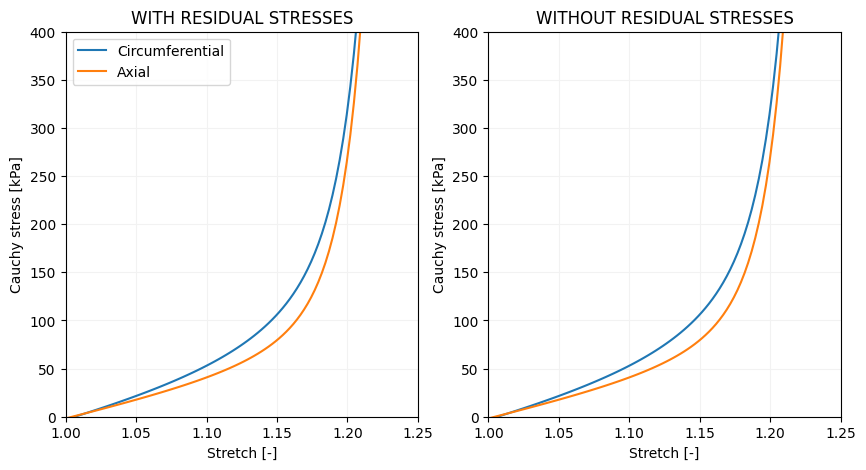

In [ ]:
#_______________________________________________________________________________
#______________________ CHANGE THESE LINES OF CODE _____________________________
#_______________________________________________________________________________

# Intimal deformation gradient to capture the residual stresses
G_res_intima_NRS = np.array([1.020, 0.987, 1/(1.020 * 0.987)])

# Medial deformation gradient to capture the residual stresses
G_res_media_NRS = np.array([0.997, 0.979, 1/(0.997 * 0.979)])

# Adventitial deformation gradient to capture the residual stresses
G_res_adventitia_NRS = np.array([0.943, 1.061, 1/(0.943 * 1.061)])

#_______________________________________________________________________________
#_______________________________________________________________________________
#_______________________________________________________________________________

# Now, the layer-specific deformation tensors can be determined by the simple composition of the
# layer-specific residual stress deformation gradient G and thevessel deformation gradient F
lambdaM_intima = lambdaM * G_res_intima_NRS
lambdaM_media = lambdaM * G_res_media_NRS
lambdaM_adventitia = lambdaM * G_res_adventitia_NRS

# Simulating the equibiaxial extension of the intima when part of the wall
[SigmaM_intima_NRS, _, _] = TwoFibreFamilyDispersion(parV_intima, lambdaM_intima, [1,1])

# Simulation the equibiaxial extension of the media when part of the wall
[SigmaM_media_NRS, _, _] = TwoFibreFamilyDispersion(parV_media, lambdaM_media, [1,1])

# Simulation the equibiaxial extension of the adventitia when part of the wall
[SigmaM_adventitia_NRS, _, _] = TwoFibreFamilyDispersion(parV_adventitia, lambdaM_adventitia, [1,1])

# Applying the Lagrange multiplier to enforce incompressibiliy
for iCoordinate in range (0,3):
  SigmaM_intima_NRS[:,iCoordinate] = SigmaM_intima_NRS[:,iCoordinate] - SigmaM_intima_NRS[:,2]
  SigmaM_media_NRS[:,iCoordinate] = SigmaM_media_NRS[:,iCoordinate] - SigmaM_media_NRS[:,2]
  SigmaM_adventitia_NRS[:,iCoordinate] = SigmaM_adventitia_NRS[:,iCoordinate] - SigmaM_adventitia_NRS[:,2]

# Calculating the layer-specific wall thicknesses
h_intima = H_intima * lambdaM_intima[:,2]
h_media = H_media * lambdaM_media[:,2]
h_adventitia = H_adventitia * lambdaM_adventitia[:,2]

# and the total wall thickness
h_wall = h_intima + h_media + h_adventitia

# The total wall stress is then the weighted average of the layer-specific stresses
SigmaM_NRS = np.zeros((100,3))
for iCoordinate in range (0,3):
  SigmaM_NRS[:,iCoordinate] = (SigmaM_intima_NRS[:,iCoordinate] * h_intima + SigmaM_media_NRS[:,iCoordinate] * h_media + SigmaM_adventitia_NRS[:,iCoordinate] * h_adventitia)/ h_wall

# Plotting result of the simulation
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(lambdaM[:,0],SigmaM[:,0])
plt.plot(lambdaM[:,1],SigmaM[:,1])
plt.title('WITH RESIDUAL STRESSES')
plt.ylabel('Cauchy stress [kPa]')
plt.xlabel('Stretch [-]')
plt.axis([1, 1.25, 0, 400])
plt.legend(['Circumferential','Axial'])
plt.grid(visible=True,color='0.95')

# Plotting result of the simulation
plt.subplot(1,2,2)
plt.plot(lambdaM[:,0],SigmaM_NRS[:,0])
plt.plot(lambdaM[:,1],SigmaM_NRS[:,1])
plt.title('WITHOUT RESIDUAL STRESSES')
plt.ylabel('Cauchy stress [kPa]')
plt.xlabel('Stretch [-]')
plt.axis([1, 1.25, 0, 400])
plt.grid(visible=True,color='0.95')

As shown in the figure above, neglecting residual stresses yields a slightly more non-linear response of the arterial wall tissue both in the circumferential direction, which can be appreciated by noting the leftward shift of the high-stress part of the blue curve in the right plot compared to the left one.

Through the tri-layered formulation, we can compare the individual contributions to the total wall stress of the three layers in the two scenarios, thereby understanding how this difference in behaviour arises from the differential engagement of layers.

(np.float64(1.0), np.float64(1.2), np.float64(0.0), np.float64(400.0))

<Figure size 1000x1000 with 0 Axes>

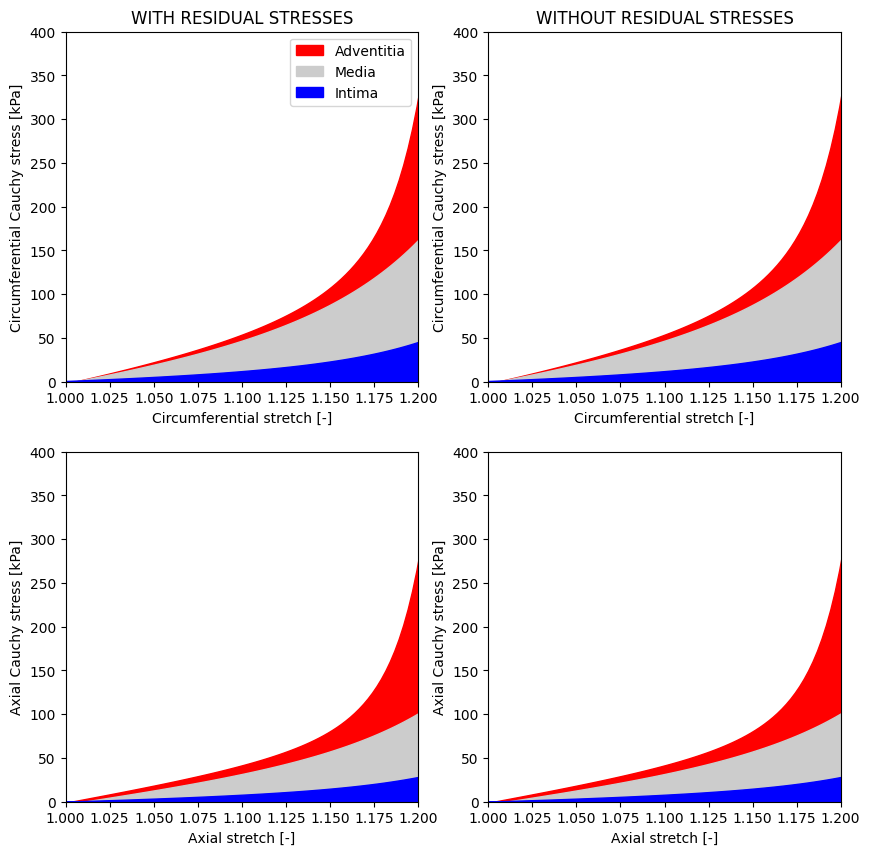

In [ ]:
# Calculating the layer-specific load bearing
loadBearing_intima = np.zeros((100,3))
loadBearing_media = np.zeros((100,3))
loadBearing_intima_NRS = np.zeros((100,3))
loadBearing_media_NRS = np.zeros((100,3))

for iCoordinate in range (0,3):
  loadBearing_intima[:,iCoordinate] = (SigmaM_intima[:,iCoordinate] * h_intima)/ h_wall
  loadBearing_media[:,iCoordinate] = (SigmaM_intima[:,iCoordinate] * h_intima + SigmaM_media[:,iCoordinate] * h_media)/ h_wall
  loadBearing_intima_NRS[:,iCoordinate] = (SigmaM_intima_NRS[:,iCoordinate] * h_intima)/ h_wall
  loadBearing_media_NRS[:,iCoordinate] = (SigmaM_intima_NRS[:,iCoordinate] * h_intima + SigmaM_media_NRS[:,iCoordinate] * h_media)/ h_wall

plt.figure(figsize=(10, 10))

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10, 10))
ax1.fill_between(lambdaM[:,0],SigmaM[:,0],color='r')
ax1.fill_between(lambdaM[:,0],loadBearing_media[:,0],color='0.8')
ax1.fill_between(lambdaM[:,0],loadBearing_intima[:,0],color='b')
ax1.set_ylabel('Circumferential Cauchy stress [kPa]')
ax1.set_xlabel('Circumferential stretch [-]')
ax1.axis([1, 1.20, 0, 400])
ax1.legend(['Adventitia','Media','Intima'])
ax1.set_title('WITH RESIDUAL STRESSES')

ax2.fill_between(lambdaM[:,1],SigmaM[:,1],color='r')
ax2.fill_between(lambdaM[:,1],loadBearing_media[:,1],color='0.8')
ax2.fill_between(lambdaM[:,1],loadBearing_intima[:,1],color='b')
ax2.set_ylabel('Axial Cauchy stress [kPa]')
ax2.set_xlabel('Axial stretch [-]')
ax2.axis([1, 1.20, 0, 400])

ax3.fill_between(lambdaM[:,0],SigmaM_NRS[:,0],color='r')
ax3.fill_between(lambdaM[:,0],loadBearing_media_NRS[:,0],color='0.8')
ax3.fill_between(lambdaM[:,0],loadBearing_intima_NRS[:,0],color='b')
ax3.set_ylabel('Circumferential Cauchy stress [kPa]')
ax3.set_xlabel('Circumferential stretch [-]')
ax3.axis([1, 1.20, 0, 400])
ax3.set_title('WITHOUT RESIDUAL STRESSES')

ax4.fill_between(lambdaM[:,1],SigmaM_NRS[:,1],color='r')
ax4.fill_between(lambdaM[:,1],loadBearing_media_NRS[:,1],color='0.8')
ax4.fill_between(lambdaM[:,1],loadBearing_intima_NRS[:,1],color='b')
ax4.set_ylabel('Axial Cauchy stress [kPa]')
ax4.set_xlabel('Axial stretch [-]')
ax4.axis([1, 1.20, 0, 400])


In both the circumferential and axial responses, neglecting residual stresses (right plots) leads to a smaller engagement of the intima and a larger engagement of the adventitia, especially at high deformations. Given the strongly non-linear response of the isolated adventitia, it is not surprising to observe an increase in non-linearity of the wall behaviour when neglecting residual stresses.

$\text{ }$

**3.3. Simulation of physiological extension-inflation**

Up until this point, we have managed to generate a tri-layered model of the thoracic aortic wall that can describe the biomechanical response of the tissue to planar deformations as achievable, e.g., with uniaxial or planar biaxial testing.

However, loading an artery in such devices requires flattening a naturally cylindrical sample into a tissue slab. This "flattening" can also be described by a deformation gradient, which is compressive and tensile in the outer and inner the half of the wall thickness, respectively. The calculation of its inverse is crucial for simulating the biomechanics of the tissue in conditions that are relevant to vascular physiology.

Let's, hence, define layer-specific deformation gradients $\textbf{F}_{\text{close},i}$ mapping the deformation of the three layers from the flat slab of tissue to a closed tri-layered cylindrical vessel.

In [ ]:
# Intimal closing deformation gradient
F_close_intima = np.array([0.916, 1.024, 1/(0.916 * 1.024)])     # [circumferential, axial, radial]

# Medial closing deformation gradient
F_close_media = np.array([0.983, 1.024, 1/(0.983 * 1.024)])      # [circumferential, axial, radial]

# Adventitial closing deformation gradient
F_close_adventitia = np.array([1.063, 1.024, 1/(1.063 * 1.024)]) # [circumferential, axial, radial]

We can now simulate the response of the thoracic aorta to physiological pressurisation and extension along its main axis.

Text(0, 0.5, 'Reduced (or transducer) axial force [N]')

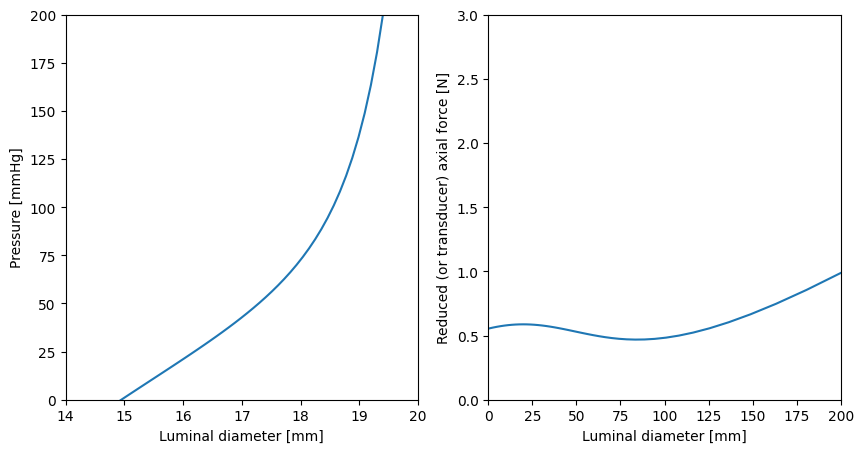

In [ ]:
# Let's define the deformation of the vessel lumen
lambda_z_iv = 1.04 * np.ones((100,1)) # in vivo-like axial stretch
lambda_theta = np.linspace(0.8,1.5,100).reshape(100,1) # circumferential deformation

# and calculate the layer thicknesses in the unloaded cylinder
H_intima_cyl = H_intima * G_res_intima[2] * F_close_intima[2]
H_media_cyl = H_media * G_res_media[2] * F_close_media[2]
H_adventitia_cyl = H_adventitia * G_res_adventitia[2] * F_close_adventitia[2]

# and the total wall thickness
h_wall_cyl = H_intima_cyl + H_media_cyl + H_adventitia_cyl

# Given the luminal radius, we can calculate the mid-wall radius of each layer
R_lumen = 7.4536 # in [mm]
R_intima = R_lumen + H_intima_cyl/2 # in [mm]
R_intima_media = R_lumen + H_intima_cyl # in [mm]
R_media = R_lumen + H_intima_cyl + H_media_cyl/2 # in [mm]
R_media_adventitia = R_lumen + H_intima_cyl + H_media_cyl # in [mm]
R_adventitia = R_lumen + H_intima_cyl + H_media_cyl + H_adventitia_cyl/2 # in [mm]
R_outer_wall = R_lumen + H_intima_cyl + H_media_cyl + H_adventitia_cyl # in [mm]

# This allows us to calculate the corresponding deformation of each layer
# (noting that the inflation of a cylinder yields a radially varying deformation)
lambda_theta_intima = np.sqrt((R_lumen * lambda_theta / R_intima)**2 + (R_intima**2 - R_lumen**2)/(R_intima**2 * lambda_z_iv))
lambda_r_intima = 1 / (lambda_theta_intima * lambda_z_iv)

lambda_theta_media = np.sqrt((R_lumen * lambda_theta / R_media)**2 + (R_media**2 - R_lumen**2)/(R_media**2 * lambda_z_iv))
lambda_r_media = 1 / (lambda_theta_media * lambda_z_iv)

lambda_theta_adventitia = np.sqrt((R_lumen * lambda_theta / R_adventitia)**2 + (R_adventitia**2 - R_lumen**2)/(R_adventitia**2 * lambda_z_iv))
lambda_r_adventitia = 1 / (lambda_theta_adventitia * lambda_z_iv)

# And the layer-specific deformed mid-wall radii and thicknesses
lambda_theta_intima_media = np.sqrt((R_lumen * lambda_theta / R_intima_media)**2 + (R_intima_media**2 - R_lumen**2)/(R_intima_media**2 * lambda_z_iv))
lambda_theta_media_adventitia = np.sqrt((R_lumen * lambda_theta / R_media_adventitia)**2 + (R_media_adventitia**2 - R_lumen**2)/(R_media_adventitia**2 * lambda_z_iv))
lambda_theta_outer_wall = np.sqrt((R_lumen * lambda_theta / R_outer_wall)**2 + (R_outer_wall**2 - R_lumen**2)/(R_outer_wall**2 * lambda_z_iv))

h_intima_cyl = (R_intima_media * lambda_theta_intima_media - R_lumen * lambda_theta).reshape(100,1)
h_media_cyl = (R_media_adventitia * lambda_theta_media_adventitia - R_intima_media * lambda_theta_intima_media).reshape(100,1)
h_adventitia_cyl = (R_outer_wall * lambda_theta_outer_wall - R_media_adventitia * lambda_theta_media_adventitia).reshape(100,1)

r_intima_cyl = (R_intima * lambda_theta_intima).reshape(100,1)
r_media_cyl = (R_media * lambda_theta_media).reshape(100,1)
r_adventitia_cyl = (R_adventitia * lambda_theta_adventitia).reshape(100,1)

# Defining the extension-inflation deformation tensor F at the intimal radial coordinate
lambdaM_intima = np.zeros((100,3))
lambdaM_intima[:,0:1] = lambda_theta_intima
lambdaM_intima[:,1:2] = lambda_z_iv
lambdaM_intima[:,2:3] = lambda_r_intima

# Defining the extension-inflation deformation tensor F at the medial radial coordinate
lambdaM_media = np.zeros((100,3))
lambdaM_media[:,0:1] = lambda_theta_media
lambdaM_media[:,1:2] = lambda_z_iv
lambdaM_media[:,2:3] = lambda_r_media

# Defining the extension-inflation deformation tensor F at the adventitial radial coordinate
lambdaM_adventitia = np.zeros((100,3))
lambdaM_adventitia[:,0:1] = lambda_theta_adventitia
lambdaM_adventitia[:,1:2] = lambda_z_iv
lambdaM_adventitia[:,2:3] = lambda_r_adventitia

# Now, the layer-specific deformation tensors can be determined by the composition of the
# layer-specific residual stress deformation gradient G, the layer-specific closing deformation
# gradient F_close, and the vessel deformation gradient F
lambdaM_intima_tot = lambdaM_intima * G_res_intima * F_close_intima
lambdaM_media_tot = lambdaM_media * G_res_media * F_close_media
lambdaM_adventitia_tot = lambdaM_adventitia * G_res_adventitia * F_close_adventitia

# Simulating the intimal response to extension-inflation
[SigmaM_intima, _, _] = TwoFibreFamilyDispersion(parV_intima, lambdaM_intima_tot, [1,1])

# Simulating the medial response to extension-inflation
[SigmaM_media, _, _] = TwoFibreFamilyDispersion(parV_media, lambdaM_media_tot, [1,1])

# Simulation the equibiaxial extension of the adventitia when part of the wall
[SigmaM_adventitia, _, _] = TwoFibreFamilyDispersion(parV_adventitia, lambdaM_adventitia_tot, [1,1])

# Calculating transmural pressure
kPa2mmHg = 1000/133.32
P = kPa2mmHg * ((SigmaM_intima[:,0:1] - SigmaM_intima[:,2:3]) * h_intima_cyl / r_intima_cyl + (SigmaM_media[:,0:1] - SigmaM_media[:,2:3]) * h_media_cyl / r_media_cyl + (SigmaM_adventitia[:,0:1] - SigmaM_adventitia[:,2:3]) * h_adventitia_cyl / r_adventitia_cyl)

# Calculating the reduced axial force
Ft = np.pi / 1000 * ((2 * SigmaM_intima[:,1:2] - SigmaM_intima[:,0:1] - SigmaM_intima[:,2:3]) * h_intima_cyl * r_intima_cyl + (2 * SigmaM_media[:,1:2] - SigmaM_media[:,0:1] - SigmaM_media[:,2:3]) * h_media_cyl * r_media_cyl + (2 * SigmaM_adventitia[:,1:2] - SigmaM_adventitia[:,0:1] - SigmaM_adventitia[:,2:3]) * h_adventitia_cyl * r_adventitia_cyl)


plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(2 * R_lumen * lambda_theta, P)
plt.axis([14,20,0,200])
plt.xlabel('Luminal diameter [mm]')
plt.ylabel('Pressure [mmHg]')

plt.subplot(1,2,2)
plt.plot(P,Ft)
plt.axis([0,200,0,3])
plt.xlabel('Luminal diameter [mm]')
plt.ylabel('Reduced (or transducer) axial force [N]')


Note the graph on the right: the reduced axial force is nearly independent of the acting pressure, indicating that the simulation has been run for a physiological level of axial elongation.

As for the equibiaxial deformation example, we can now split the pressure-diameter relationship into individual contributions from each layer, highlighting their role in the physiological function of the aorta.

(np.float64(14.0), np.float64(19.2), np.float64(0.0), np.float64(200.0))

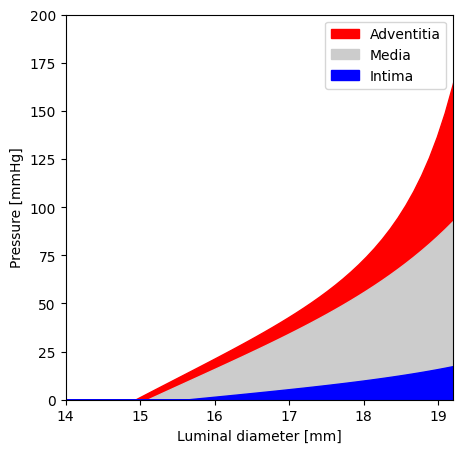

In [ ]:
# Calculating the layer-specific pressure load bearing
P_loadBearing_intima = kPa2mmHg * ((SigmaM_intima[:,0:1] - SigmaM_intima[:,2:3]) * h_intima_cyl / r_intima_cyl)
P_loadBearing_media = kPa2mmHg * ((SigmaM_intima[:,0:1] - SigmaM_intima[:,2:3]) * h_intima_cyl / r_intima_cyl + (SigmaM_media[:,0:1] - SigmaM_media[:,2:3]) * h_media_cyl / r_media_cyl)
r_lumen = 2 * R_lumen * lambda_theta

for iStretch in range (0,100):
  if(P_loadBearing_media[iStretch] > P[iStretch]):
    P_loadBearing_media[iStretch] = P[iStretch]
  if(P_loadBearing_intima[iStretch] > P_loadBearing_media[iStretch]):
    P_loadBearing_intima[iStretch] = P_loadBearing_media[iStretch]

fig, (ax1) = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(5, 5))
ax1.fill_between(r_lumen[:,0],P[:,0],color='r')
ax1.fill_between(r_lumen[:,0],P_loadBearing_media[:,0],color='0.8')
ax1.fill_between(r_lumen[:,0],P_loadBearing_intima[:,0],color='b')
ax1.set_ylabel('Pressure [mmHg]')
ax1.set_xlabel('Luminal diameter [mm]')
ax1.legend(['Adventitia','Media','Intima'])
plt.axis([14,19.2,0,200])

Note the protective function of the adventitia, providing limited contribution to the mechanics of the wall at physiological and sub-physiological pressures whilst bearing approximately 50% of the pressure load at 200 mmHg.

We can also evaluate the intrinsic differences in loading conditions between a planar biaxial tester and a physiologically-inspired biaxial tester that replicates the loading arteries undergo in vivo. This can be done by neglecting the deformation gradient that maps the deformation of the slab into a cylinder. This can be achieved by setting $\textbf{F}_\text{close} = \text{diag}[1, 1, 1]$.

In the code below, $\textbf{F}_\text{close}$ is defined in the first three lines. Modify them to set $\textbf{F}_\text{close} = \text{diag}[1, 1, 1]$ for all layers.

(np.float64(14.0), np.float64(19.2), np.float64(0.0), np.float64(200.0))

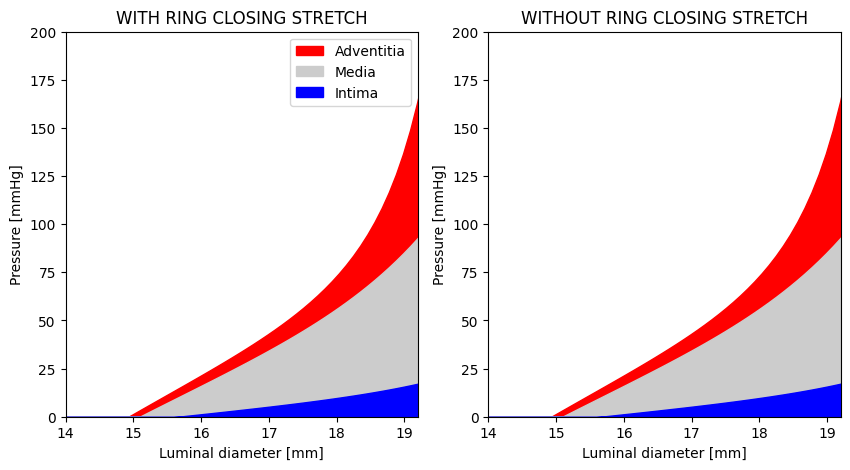

In [ ]:
#_______________________________________________________________________________
#______________________ CHANGE THESE LINES OF CODE _____________________________
#_______________________________________________________________________________

# Intimal closing deformation gradient
F_close_intima_NCS = np.array([0.916, 1.024, 1/(0.916 * 1.024)])     # [circumferential, axial, radial]

# Medial closing deformation gradient
F_close_media_NCS = np.array([0.983, 1.024, 1/(0.983 * 1.024)])      # [circumferential, axial, radial]

# Adventitial closing deformation gradient
F_close_adventitia_NCS = np.array([1.063, 1.024, 1/(1.063 * 1.024)]) # [circumferential, axial, radial]

#_______________________________________________________________________________
#_______________________________________________________________________________
#_______________________________________________________________________________

# Let's define the deformation of the vessel lumen
lambda_z_iv = 1.04 * np.ones((100,1)) # in vivo-like axial stretch
lambda_theta = np.linspace(0.8,1.5,100).reshape(100,1) # circumferential deformation

# and calculate the layer thicknesses in the unloaded cylinder
H_intima_cyl_NCS = H_intima * G_res_intima[2] * F_close_intima_NCS[2]
H_media_cyl_NCS = H_media * G_res_media[2] * F_close_media_NCS[2]
H_adventitia_cyl_NCS = H_adventitia * G_res_adventitia[2] * F_close_adventitia_NCS[2]

# and the total wall thickness
h_wall_cyl_NCS = H_intima_cyl_NCS + H_media_cyl_NCS + H_adventitia_cyl_NCS

# Given the luminal radius, we can calculate the mid-wall radius of each layer
R_intima_NCS = R_lumen + H_intima_cyl_NCS/2 # in [mm]
R_intima_media_NCS = R_lumen + H_intima_cyl_NCS # in [mm]
R_media_NCS = R_lumen + H_intima_cyl_NCS + H_media_cyl_NCS/2 # in [mm]
R_media_adventitia_NCS = R_lumen + H_intima_cyl_NCS + H_media_cyl_NCS # in [mm]
R_adventitia_NCS = R_lumen + H_intima_cyl_NCS + H_media_cyl_NCS + H_adventitia_cyl_NCS/2 # in [mm]
R_outer_wall_NCS = R_lumen + H_intima_cyl_NCS + H_media_cyl_NCS + H_adventitia_cyl_NCS # in [mm]

# This allows us to calculate the corresponding deformation of each layer
# (noting that the inflation of a cylinder yields a radially varying deformation)
lambda_theta_intima_NCS = np.sqrt((R_lumen * lambda_theta / R_intima_NCS)**2 + (R_intima_NCS**2 - R_lumen**2)/(R_intima_NCS**2 * lambda_z_iv))
lambda_r_intima_NCS = 1 / (lambda_theta_intima_NCS * lambda_z_iv)

lambda_theta_media_NCS = np.sqrt((R_lumen * lambda_theta / R_media_NCS)**2 + (R_media_NCS**2 - R_lumen**2)/(R_media_NCS**2 * lambda_z_iv))
lambda_r_media_NCS = 1 / (lambda_theta_media_NCS * lambda_z_iv)

lambda_theta_adventitia_NCS = np.sqrt((R_lumen * lambda_theta / R_adventitia_NCS)**2 + (R_adventitia_NCS**2 - R_lumen**2)/(R_adventitia_NCS**2 * lambda_z_iv))
lambda_r_adventitia_NCS = 1 / (lambda_theta_adventitia_NCS * lambda_z_iv)

# And the layer-specific deformed mid-wall radii and thicknesses
lambda_theta_intima_media_NCS = np.sqrt((R_lumen * lambda_theta / R_intima_media_NCS)**2 + (R_intima_media_NCS**2 - R_lumen**2)/(R_intima_media_NCS**2 * lambda_z_iv))
lambda_theta_media_adventitia_NCS = np.sqrt((R_lumen * lambda_theta / R_media_adventitia_NCS)**2 + (R_media_adventitia_NCS**2 - R_lumen**2)/(R_media_adventitia_NCS**2 * lambda_z_iv))
lambda_theta_outer_wall_NCS = np.sqrt((R_lumen * lambda_theta / R_outer_wall_NCS)**2 + (R_outer_wall_NCS**2 - R_lumen**2)/(R_outer_wall_NCS**2 * lambda_z_iv))

h_intima_cyl_NCS = (R_intima_media_NCS * lambda_theta_intima_media_NCS - R_lumen * lambda_theta).reshape(100,1)
h_media_cyl_NCS = (R_media_adventitia_NCS * lambda_theta_media_adventitia_NCS - R_intima_media_NCS * lambda_theta_intima_media_NCS).reshape(100,1)
h_adventitia_cyl_NCS = (R_outer_wall_NCS * lambda_theta_outer_wall_NCS - R_media_adventitia_NCS * lambda_theta_media_adventitia_NCS).reshape(100,1)

r_intima_cyl_NCS = (R_intima_NCS * lambda_theta_intima_NCS).reshape(100,1)
r_media_cyl_NCS = (R_media_NCS * lambda_theta_media_NCS).reshape(100,1)
r_adventitia_cyl_NCS = (R_adventitia_NCS * lambda_theta_adventitia_NCS).reshape(100,1)

# Defining the extension-inflation deformation tensor F at the intimal radial coordinate
lambdaM_intima_NCS = np.zeros((100,3))
lambdaM_intima_NCS[:,0:1] = lambda_theta_intima_NCS
lambdaM_intima_NCS[:,1:2] = lambda_z_iv
lambdaM_intima_NCS[:,2:3] = lambda_r_intima_NCS

# Defining the extension-inflation deformation tensor F at the medial radial coordinate
lambdaM_media_NCS = np.zeros((100,3))
lambdaM_media_NCS[:,0:1] = lambda_theta_media_NCS
lambdaM_media_NCS[:,1:2] = lambda_z_iv
lambdaM_media_NCS[:,2:3] = lambda_r_media_NCS

# Defining the extension-inflation deformation tensor F at the adventitial radial coordinate
lambdaM_adventitia_NCS = np.zeros((100,3))
lambdaM_adventitia_NCS[:,0:1] = lambda_theta_adventitia_NCS
lambdaM_adventitia_NCS[:,1:2] = lambda_z_iv
lambdaM_adventitia_NCS[:,2:3] = lambda_r_adventitia_NCS

# Now, the layer-specific deformation tensors can be determined by the composition of the
# layer-specific residual stress deformation gradient G, the layer-specific closing deformation
# gradient F_close, and the vessel deformation gradient F
lambdaM_intima_tot_NCS = lambdaM_intima_NCS * G_res_intima * F_close_intima_NCS
lambdaM_media_tot_NCS = lambdaM_media_NCS * G_res_media * F_close_media_NCS
lambdaM_adventitia_tot_NCS = lambdaM_adventitia_NCS * G_res_adventitia * F_close_adventitia_NCS

# Simulating the intimal response to extension-inflation
[SigmaM_intima_NCS, _, _] = TwoFibreFamilyDispersion(parV_intima, lambdaM_intima_tot_NCS, [1,1])

# Simulating the medial response to extension-inflation
[SigmaM_media_NCS, _, _] = TwoFibreFamilyDispersion(parV_media, lambdaM_media_tot_NCS, [1,1])

# Simulation the equibiaxial extension of the adventitia when part of the wall
[SigmaM_adventitia_NCS, _, _] = TwoFibreFamilyDispersion(parV_adventitia, lambdaM_adventitia_tot_NCS, [1,1])

# Calculating transmural pressure
kPa2mmHg = 1000/133.32
P_NCS = kPa2mmHg * ((SigmaM_intima_NCS[:,0:1] - SigmaM_intima_NCS[:,2:3]) * h_intima_cyl_NCS / r_intima_cyl_NCS + (SigmaM_media_NCS[:,0:1] - SigmaM_media_NCS[:,2:3]) * h_media_cyl_NCS / r_media_cyl_NCS + (SigmaM_adventitia_NCS[:,0:1] - SigmaM_adventitia_NCS[:,2:3]) * h_adventitia_cyl_NCS / r_adventitia_cyl_NCS)

# Calculating the reduced axial force
Ft_NCS = np.pi / 1000 * ((2 * SigmaM_intima_NCS[:,1:2] - SigmaM_intima_NCS[:,0:1] - SigmaM_intima_NCS[:,2:3]) * h_intima_cyl_NCS * r_intima_cyl_NCS + (2 * SigmaM_media_NCS[:,1:2] - SigmaM_media_NCS[:,0:1] - SigmaM_media_NCS[:,2:3]) * h_media_cyl_NCS * r_media_cyl_NCS + (2 * SigmaM_adventitia[:,1:2] - SigmaM_adventitia_NCS[:,0:1] - SigmaM_adventitia_NCS[:,2:3]) * h_adventitia_cyl_NCS * r_adventitia_cyl_NCS)

# Calculating the layer-specific pressure load bearing
P_loadBearing_intima_NCS = kPa2mmHg * ((SigmaM_intima_NCS[:,0:1] - SigmaM_intima_NCS[:,2:3]) * h_intima_cyl_NCS / r_intima_cyl_NCS)
P_loadBearing_media_NCS = kPa2mmHg * ((SigmaM_intima_NCS[:,0:1] - SigmaM_intima_NCS[:,2:3]) * h_intima_cyl_NCS / r_intima_cyl_NCS + (SigmaM_media_NCS[:,0:1] - SigmaM_media_NCS[:,2:3]) * h_media_cyl_NCS / r_media_cyl_NCS)
r_lumen_NCS = 2 * R_lumen * lambda_theta

for iStretch in range (0,100):
  if(P_loadBearing_media_NCS[iStretch] > P_NCS[iStretch]):
    P_loadBearing_media_NCS[iStretch] = P_NCS[iStretch]
  if(P_loadBearing_intima_NCS[iStretch] > P_loadBearing_media_NCS[iStretch]):
    P_loadBearing_intima_NCS[iStretch] = P_loadBearing_media_NCS[iStretch]

fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))
ax1.fill_between(r_lumen[:,0],P[:,0],color='r')
ax1.fill_between(r_lumen[:,0],P_loadBearing_media[:,0],color='0.8')
ax1.fill_between(r_lumen[:,0],P_loadBearing_intima[:,0],color='b')
ax1.set_title('WITH RING CLOSING STRETCH')
ax1.set_ylabel('Pressure [mmHg]')
ax1.set_xlabel('Luminal diameter [mm]')
ax1.legend(['Adventitia','Media','Intima'])
ax1.axis([14,19.2,0,200])

ax2.fill_between(r_lumen_NCS[:,0],P_NCS[:,0],color='r')
ax2.fill_between(r_lumen_NCS[:,0],P_loadBearing_media_NCS[:,0],color='0.8')
ax2.fill_between(r_lumen_NCS[:,0],P_loadBearing_intima_NCS[:,0],color='b')
ax2.set_title('WITHOUT RING CLOSING STRETCH')
ax2.set_ylabel('Pressure [mmHg]')
ax2.set_xlabel('Luminal diameter [mm]')
ax2.axis([14,19.2,0,200])


What changed in the graph above? How engaged are the intima, media, and adventitia when the cylinder closing deformation gradient is neglected?

Planar biaxial testing mostly assesses the response of the intima and media layer, with the intima layer bearing a much larger share of the load compared to when responding to physiological extension-inflation. Conversely, the adventitia is almost completely not engaged. This is not surprising if one thinks that closing the slab into a cylinder entails a compressive deformation of the inner part and a stretching of the outer part of the wall.

$\text{}$

**3.4. Adding smooth muscle cell contraction**

The current tri-layered constitutive model only captures the passive biomechanics of the aorta. However, arteries, including the aorta, can modulate their behaviour thorugh the active contraction of smooth muscle cells. Let's expand the tri-layered model to add this level of physiological complexity.

We take the following formulation that describe the bell-shaped stress-stretch curve for the active VSMC contraction:

$$
\sigma_{\theta\theta,\text{act}} = T_\text{act}(1-\rho)\lambda_\theta e^{\frac{[(1-2\rho)(\lambda_\theta-\lambda_{\theta,\text{opt}})+\rho(\lambda_\theta-\lambda_{\theta,\text{opt}}+\lambda_z-\lambda_{z,\text{opt}})]^2}{2\omega^2}},
$$ and

$$
\sigma_{zz,\text{act}} = T_\text{act}\rho\lambda_z e^{\frac{[(1-2\rho)(\lambda_\theta-\lambda_{\theta,\text{opt}})+\rho(\lambda_\theta-\lambda_{\theta,\text{opt}}+\lambda_z-\lambda_{z,\text{opt}})]^2}{2\omega^2}},
$$
where:
* $T_\text{act}$ is a stress-like parameter describing the peak stress generated by VSMC contraction,
* $\rho$ is a dispersion parameter, which indicates the in-plane orientation dispersion of the VSMC orientation about the circumferential direction,
* $\lambda_{\theta,\text{opt}}$ and $\lambda_{z,\text{opt}}$ are the optimal circumferential and axial stretches at which smooth muscle cells generate their peak stress, and
* $\omega$ is a parameter controlling the width of the gaussian function.

The following python function implements this model.

The full description of this active stress model can be found in the supplement of this paper:
* Koen W. F. van der Laan, Cédric H. G. Neutel, Margarita G. Pencheva, Callan D. Wesley, Dustin N. Krüger, Casper G. Schalkwijk, Guido R. Y. De Meyer, Wim Martinet, Koen D. Reesink, Tammo Delhaas, Alessandro Giudici, Pieter-Jan Guns, and Bart Spronck
American Journal of Physiology-Cell Physiology 2025 329:5, C1398-C1410

In [ ]:
def GiudiciVSMCmodel(parameterV,lambdaM):
    """
    This model expands on Rachev's one (see rechevGaussian) to allow for a biaxial response of VSMCs. The contribution
    of VSMC still follows a Guassian function, which, however, incorporate a dispersion coefficient which weights the
    VSMC stretch function as a summation between a purely circumferential term and an in-plane isotropic term.

    parameterV is the 2-element vector of model parameters where:
       position 0: VSMC stress-like parameter
       position 1: VSMC orientation dispersion parameter (takes values between 0 and 0.5)
       position 2: parameter defining the width of the Gaussian (omega)
       position 3: optimal VSMC stretch in the circumferential direction
       position 4: optimal VSMC stretch in the axial direction
       position 5: VSMC contraction level term S1 = [0, 1]

    For a detailed description of the model, please refer to van der Laan et al. investigating vascular ageing in
    C57Bl/6J mice: Impaired modulation of aortic stiffness by smooth muscle cells. [in preparation].

    For a detailed description of the small-on-large formulation refer to Baek et al. Theory of small on large:
    Potential utility in computations of fluid-solid interactions in arteries. Computer methods in applied mechanics
    and engineering 207, 196(31-32), pp. 3070-3078.
    """
    # Re-assigning parameters
    T_act = parameterV[0]
    rho = parameterV[1]
    omega = parameterV[2]
    lambda_theta_opt = parameterV[3]
    lambda_z_opt = parameterV[4]

    # Initialising output vectors
    sigmaM = np.zeros(np.shape(lambdaM))
    C_M = np.zeros(np.shape(lambdaM))

    # VSMC strain
    lambda_VSMC = (1 - 2 * rho) * (lambdaM[:, 0] - lambda_theta_opt) + rho * (lambdaM[:, 0] - lambda_theta_opt +
                                                                                           lambdaM[:, 1] - lambda_z_opt)
    # Strain energy density function
    W_V = T_act * np.sqrt(- np.pi * omega**2 / 2) * (sp.special.erf(np.sqrt(-1 / (2 *
        omega**2)) * lambda_VSMC) - sp.special.erf(np.sqrt(-1 / (2 * omega**2)) * ((1 - 2 *
        rho) * (1 - lambda_theta_opt) + rho * (2 - lambda_theta_opt - lambda_z_opt)))
        )

    # Circumferential extra Cauchy stress
    sigmaM[:,0] = T_act * lambdaM[:, 0] * (1 - rho) * np.exp(-lambda_VSMC**2 / (2 * omega**2))

    # Axial extra Cauchy stress
    sigmaM[:,1] = T_act * lambdaM[:, 1] * rho * np.exp(-lambda_VSMC**2 / (2 * omega**2))

    # Radial extra Cauchy stress
    sigmaM[:,2] = 0

    # Circumferential stiffness
    C_M[:,0] = 2 * sigmaM[:,0] + (T_act * lambdaM[:, 0]**2 * (1 - rho)**2 * (-lambda_VSMC /
                               omega**2) * np.exp(-lambda_VSMC**2 / (2 * omega**2))
                               )

    # Axial stiffness
    C_M[:,1] = 2 * sigmaM[:,1] + (T_act * lambdaM[:, 1]**2 * rho**2 * (-lambda_VSMC /
                               omega**2) * np.exp(-lambda_VSMC**2 / (2 * omega**2))
                               )

    return sigmaM, W_V, C_M

Let's now assign some properties (model parameters) to this contraction model. We impose $\rho=0$ to restrict our anlysis to the simplistic case in which VSMCs are assumed to generate stress only in the circumferential direction (i.e., $\sigma_{zz,\text{act}}=0$).

In [ ]:
# VSMC model parameters
T_act = 100 # Stress like parameter in [kPa]
rho = 0 # dispersion parameter in []
omega = 0.2 # width of the gaussian stress function in []
lambda_theta_opt = 1.15 # optimal circumferential stretch for maximal contraction in []
lambda_z_opt = lambda_z_iv[0,0] # optimal axial stretch for maximal contraction in []

# creating an array of VSMC model parameters
parV_VSMC = np.array([T_act, rho, omega, lambda_theta_opt, lambda_z_opt])

We can now calculate the stress generated by VSMC under the physiological deformation imposed in Section 3.3 and add this the passive biomechanical contribution provided by the extracellular matrix. We can also look at how VSMC contraction affects the pressure load distribution between layers.

/tmp/ipython-input-2288639450.py:37: RuntimeWarning: invalid value encountered in sqrt
  W_V = T_act * np.sqrt(- np.pi * omega**2 / 2) * (sp.special.erf(np.sqrt(-1 / (2 *
/tmp/ipython-input-2288639450.py:38: RuntimeWarning: invalid value encountered in sqrt
  omega**2)) * lambda_VSMC) - sp.special.erf(np.sqrt(-1 / (2 * omega**2)) * ((1 - 2 *


Text(0.5, 1.0, 'ACTIVE BEHAVIOUR')

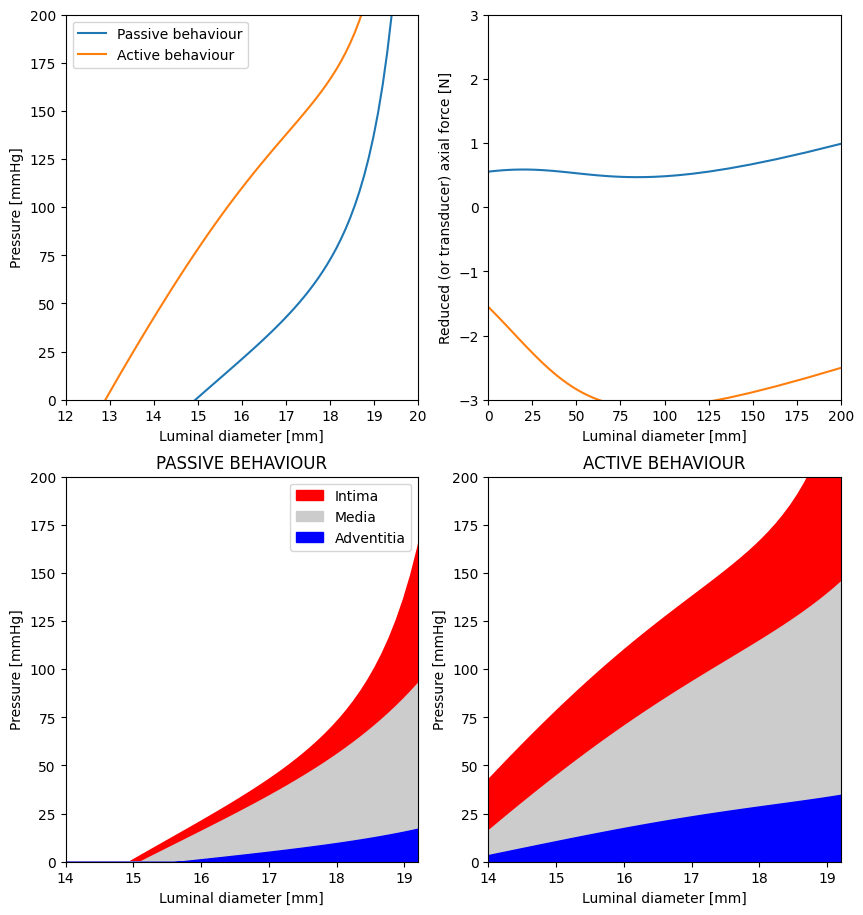

In [ ]:
# VSMC stress contribution in the intimal layer
[SigmaM_VSMC_intima, _, _] = GiudiciVSMCmodel(parV_VSMC, lambdaM_intima_tot)

# VSMC stress contribution in the medial layer
[SigmaM_VSMC_media, _, _] = GiudiciVSMCmodel(parV_VSMC, lambdaM_media_tot)

# VSMC stress contribution in the adventitial layer
[SigmaM_VSMC_adventitia, _, _] = GiudiciVSMCmodel(parV_VSMC, lambdaM_adventitia_tot)

#_______________________________________________________________________________
#______________________ CHANGE THESE LINES OF CODE _____________________________
#_______________________________________________________________________________
sigmaM_intima_tot = SigmaM_intima + SigmaM_VSMC_intima
sigmaM_media_tot = SigmaM_media + SigmaM_VSMC_media
sigmaM_adventitia_tot = SigmaM_adventitia + SigmaM_VSMC_adventitia
#_______________________________________________________________________________
#_______________________________________________________________________________
#_______________________________________________________________________________

# Calculating transmural pressure
kPa2mmHg = 1000/133.32
P_act = kPa2mmHg * ((sigmaM_intima_tot[:,0:1] - sigmaM_intima_tot[:,2:3]) * h_intima_cyl / r_intima_cyl + (sigmaM_media_tot[:,0:1] - sigmaM_media_tot[:,2:3]) * h_media_cyl / r_media_cyl + (sigmaM_adventitia_tot[:,0:1] - sigmaM_adventitia_tot[:,2:3]) * h_adventitia_cyl / r_adventitia_cyl)

# Calculating the reduced axial force
Ft_act = np.pi / 1000 * ((2 * sigmaM_intima_tot[:,1:2] - sigmaM_intima_tot[:,0:1] - sigmaM_intima_tot[:,2:3]) * h_intima_cyl * r_intima_cyl + (2 * sigmaM_media_tot[:,1:2] - sigmaM_media_tot[:,0:1] - sigmaM_media_tot[:,2:3]) * h_media_cyl * r_media_cyl + (2 * sigmaM_adventitia_tot[:,1:2] - sigmaM_adventitia_tot[:,0:1] - sigmaM_adventitia_tot[:,2:3]) * h_adventitia_cyl * r_adventitia_cyl)

# Calculating the layer-specific pressure load bearing
P_loadBearing_intima_act = kPa2mmHg * ((sigmaM_intima_tot[:,0:1] - sigmaM_intima_tot[:,2:3]) * h_intima_cyl / r_intima_cyl)
P_loadBearing_media_act = kPa2mmHg * ((sigmaM_intima_tot[:,0:1] - sigmaM_intima_tot[:,2:3]) * h_intima_cyl / r_intima_cyl + (sigmaM_media_tot[:,0:1] - sigmaM_media_tot[:,2:3]) * h_media_cyl / r_media_cyl)
r_lumen = 2 * R_lumen * lambda_theta

for iStretch in range (0,100):
  if(P_loadBearing_media_act[iStretch] > P_act[iStretch]):
    P_loadBearing_media_act[iStretch] = P_act[iStretch]
  if(P_loadBearing_intima_act[iStretch] > P_loadBearing_media_act[iStretch]):
    P_loadBearing_intima_act[iStretch] = P_loadBearing_media_act[iStretch]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10, 11))
ax1.plot(2 * R_lumen * lambda_theta, P)
ax1.plot(2 * R_lumen * lambda_theta, P_act)
ax1.set_xlabel('Luminal diameter [mm]')
ax1.set_ylabel('Pressure [mmHg]')
ax1.legend(['Passive behaviour','Active behaviour'])
ax1.set_xlim([12,20])
ax1.set_ylim([0,200])

ax2.plot(P,Ft)
ax2.plot(P,Ft_act)
ax2.set_xlim([0,200])
ax2.set_ylim([-3,3])
ax2.set_xlabel('Luminal diameter [mm]')
ax2.set_ylabel('Reduced (or transducer) axial force [N]')

ax3.fill_between(r_lumen[:,0],P[:,0],color='r')
ax3.fill_between(r_lumen[:,0],P_loadBearing_media[:,0],color='0.8')
ax3.fill_between(r_lumen[:,0],P_loadBearing_intima[:,0],color='b')
ax3.set_ylabel('Pressure [mmHg]')
ax3.set_xlabel('Luminal diameter [mm]')
ax3.legend(['Intima','Media','Adventitia'])
ax3.set_xlim([14,19.2])
ax3.set_ylim([0,200])
ax3.set_title('PASSIVE BEHAVIOUR')

ax4.fill_between(r_lumen[:,0],P_act[:,0],color='r')
ax4.fill_between(r_lumen[:,0],P_loadBearing_media_act[:,0],color='0.8')
ax4.fill_between(r_lumen[:,0],P_loadBearing_intima_act[:,0],color='b')
ax4.set_ylabel('Pressure [mmHg]')
ax4.set_xlabel('Luminal diameter [mm]')
ax4.set_xlim([14,19.2])
ax4.set_ylim([0,200])
ax4.set_title('ACTIVE BEHAVIOUR')


Note: In the code above, the stress generated by VSMC contraction is added to the passive contribution of all layers. However, we know that VSMCs are mostly located in the media, so that a more microstructurally motivated model should add VSMCs' stress only to the contribution of the medial layer. Try to modify the code above (where the total layer stress is calculated as the sum of passive and active components) accordingly. What happen to the pressure load distribution between layers?


**REFERENCES**

Additional information on this computationl model can be found in the following publications:
* A Giudici, AW Khir, JM Szafron, B Spronck. From uniaxial testing of isolated layers to a tri-layered arterial wall: a novel constitutive modelling framework. *Annals of Biomedical Engineering* 2021, 49(9): 2454-2467.
* A Giudici, B Spronck. The role of layer-specific residual stresses in arterial mechanics: analysis via a novel modelling framework. Artery Research 2022, 28(2): 41-54.
* A Giudici, B Spronck, IB Wilkinson, AW Khir. Tri-layered constitutive modelling unveils functional differences between the pig ascending and lower thoracic aorta. Journal of the Mechanical Behaviour of Biomedical Materials 2023, 141: 105752.